In [1]:
import numpy as np
import pandas as pd
import os
import math

import sklearn.tree
import sklearn.ensemble

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA

In [2]:
path = '/home/gil/Telecos/3B/APA/LAB/Competition/data/'
train = pd.read_csv(path + 'ML-MATT-CompetitionQT2021_train.csv', delimiter=';')
test = pd.read_csv(path + 'ML-MATT-CompetitionQT2021_test.xls', delimiter=';')

In [3]:
# Separate labels from data 
X = train.drop('Unusual', axis='columns')
y = train['Unusual']

# We split the data into training and validation subsets (80% and 20%) in order to validate our training
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=1, stratify = y)

X_test = test

# 2. Preprocessing the data

In [4]:
#Refactor time feature to minuts and cellName to unique identifier 1:1
def getTimeInMinutes(x):
  hh, mm  = x.split(":")
  return int(hh)* 60 + int(mm)

def createCellNameDictionary(data):
  cellList = []
  for i in data["CellName"]:
    cellList.append(i)
  cellList = set(cellList)
  cellDict = {}
  for idx, value in enumerate(cellList):
    cellDict[value]=idx
  return cellDict

def refactorFeaturesDataframe(data):
  #data["Time"] = data["Time"].apply(lambda x: getTimeInMinutes(x))
  data["TimeCos"] = data["Time"].apply(lambda x: math.cos(getTimeInMinutes(x)*math.pi/(12*60)))
  data["TimeSin"] = data["Time"].apply(lambda x: math.sin(getTimeInMinutes(x)*math.pi/(12*60)))
  del data["Time"]

  cellNameDict = createCellNameDictionary(data);
  data["CellName"] = data["CellName"].apply(lambda x: cellNameDict[x])
  return data

In [5]:
X_train_df = refactorFeaturesDataframe(X_train)
X_train = X_train_df.to_numpy()
y_train = y_train.to_numpy()
print(X_train.shape)

X_validation = refactorFeaturesDataframe(X_validation).to_numpy()
y_validation = y_validation.to_numpy()
print(X_validation.shape)

X_test = refactorFeaturesDataframe(test).to_numpy()
print(X_test.shape)

(29523, 14)
(7381, 14)
(9158, 14)


# 3. Data Visualization

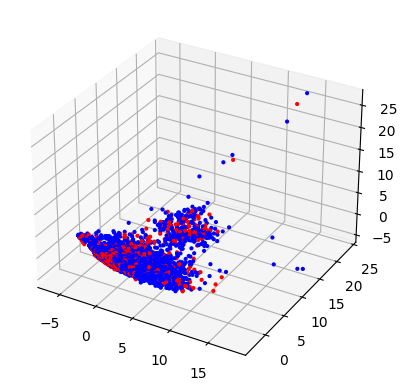

In [6]:
pca = PCA(n_components=3)
scaler = StandardScaler()
X_norm = scaler.fit_transform(X_train)
X_reduce = pca.fit_transform(X_norm)

colors=['b' if l==0 else 'r' for l in y_train]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_reduce[:,0], X_reduce[:, 1], X_reduce[:, 2], s=4, alpha=1,color=colors)
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 29523 samples in 0.083s...
[t-SNE] Computed neighbors for 29523 samples in 5.428s...
[t-SNE] Computed conditional probabilities for sample 1000 / 29523
[t-SNE] Computed conditional probabilities for sample 2000 / 29523
[t-SNE] Computed conditional probabilities for sample 3000 / 29523
[t-SNE] Computed conditional probabilities for sample 4000 / 29523
[t-SNE] Computed conditional probabilities for sample 5000 / 29523
[t-SNE] Computed conditional probabilities for sample 6000 / 29523
[t-SNE] Computed conditional probabilities for sample 7000 / 29523
[t-SNE] Computed conditional probabilities for sample 8000 / 29523
[t-SNE] Computed conditional probabilities for sample 9000 / 29523
[t-SNE] Computed conditional probabilities for sample 10000 / 29523
[t-SNE] Computed conditional probabilities for sample 11000 / 29523
[t-SNE] Computed conditional probabilities for sample 12000 / 29523
[t-SNE] Computed conditional probabilities for sa

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

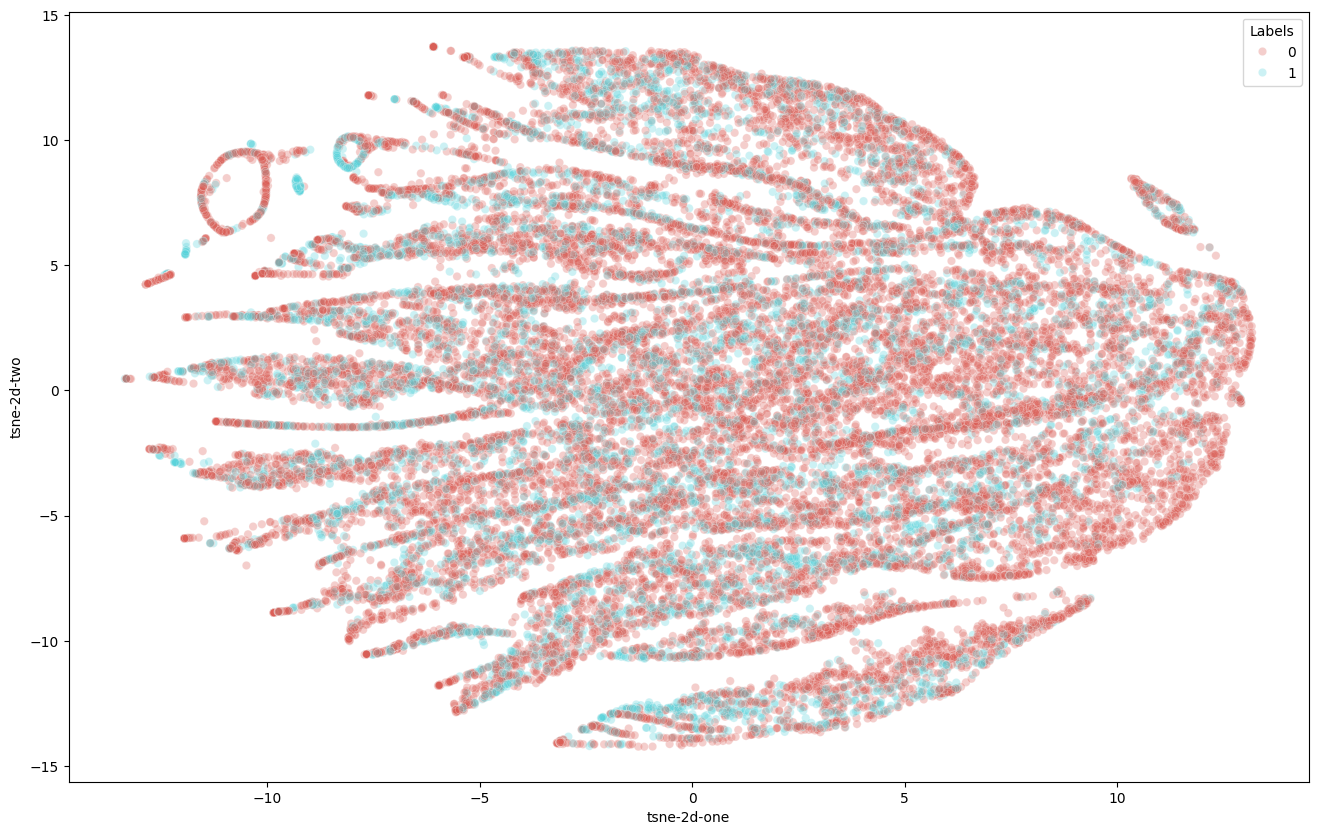

In [7]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_train)

df_subset={}
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['Labels'] = y_train

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Labels",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3
)

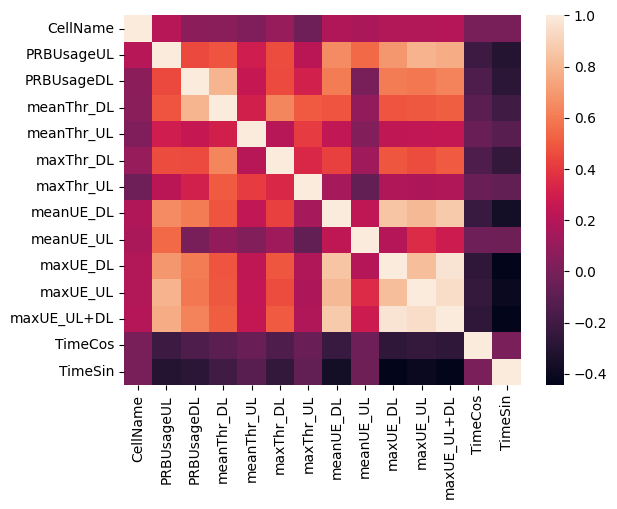

In [8]:
corrMatrix = X_train_df.corr()
sns.heatmap(corrMatrix, annot=False)
plt.show()

# 4. Predictor

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV

pipe_kmeans = Pipeline(steps=[
    ('std_slc', StandardScaler()),
    ('kmeans_clf', KMeans(n_clusters=2, random_state=1))
])

parameters_kmeans = {
    'kmeans_clf__n_clusters': [2],
}

clf_GS_kmeans = RandomizedSearchCV(
    estimator=pipe_kmeans,
    param_distributions=parameters_kmeans,
    n_jobs=10,
    verbose=1,
    cv=[(slice(None), slice(None))],
    n_iter=20
)

clf_GS_kmeans.fit(X_train, y_train)

/home/gil/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 1 folds for each of 1 candidates, totalling 1 fits


/home/gil/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/gil/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


RandomizedSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
                   estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                             ('kmeans_clf',
                                              KMeans(n_clusters=2,
                                                     random_state=1))]),
                   n_iter=20, n_jobs=10,
                   param_distributions={'kmeans_clf__n_clusters': [2]},
                   verbose=1)

In [11]:
print("Best Parameters:", clf_GS_kmeans.best_estimator_)

Best Parameters: Pipeline(steps=[('std_slc', StandardScaler()),
                ('kmeans_clf', KMeans(n_clusters=2, random_state=1))])


In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

# Assuming you have X_train, y_train, X_test, y_test datasets

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train)

cluster_labels = [np.argmax(np.bincount(y_train[kmeans.labels_ == i])) for i in range(2)]

test_cluster_labels = kmeans.predict(X_validation)

predicted_labels = [cluster_labels[label] for label in test_cluster_labels]

accuracy = accuracy_score(y_validation, predicted_labels)
print("Accuracy:", accuracy)

/home/gil/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Accuracy: 0.7240211353475139


In [133]:
from xgboost import XGBClassifier, plot_importance
from joblib import dump, load
# from google.colab import files
from scipy.stats import uniform, randint

pipe = Pipeline(steps=[('std_slc', StandardScaler()),
                       ('xgb_clf', XGBClassifier(random_state=1,
                                                    scale_pos_weight=7,
                                                    colsample_bytree= 0.13137077780333722,
                                                    eta= 0.44303994079253584,
                                                    gamma= 0.44387153143053776,
                                                    learning_rate= 0.36592512350123696,
                                                    max_depth= 16,
                                                    min_child_weight= 1,
                                                    n_estimators= 743,
                                                    subsample= 0.9954777036558068))])
  
parameters = {
# 'xgb_clf__eta'    : uniform(0.2, 0.35),
# "xgb_clf__colsample_bytree": uniform(0.05, 0.2),
# "xgb_clf__min_child_weight": randint(1, 5),
# "xgb_clf__gamma": uniform(0.35, 0.6),
# "xgb_clf__learning_rate": uniform(0.1, 0.3), # default 0.1 
# "xgb_clf__max_depth": randint(10, 30), # default 3
# "xgb_clf__n_estimators": randint(500, 1000), # default 100
# "xgb_clf__subsample": uniform(0.6, 0.99)
}

#clf_GS = RandomizedSearchCV(estimator=pipe, param_distributions=parameters, n_jobs=10, verbose=1, cv=5, n_iter= 500)  
clf_GS = RandomizedSearchCV(estimator=pipe, param_distributions=parameters, n_jobs=10, verbose=1, cv=[(slice(None), slice(None))], n_iter= 1)
clf_GS.fit(X_train, y_train) 

/home/gil/.local/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/gil/.local/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 0.22.2.post1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


XGBoostError: [17:37:47] /workspace/src/learner.cc:1182: Check failed: header == serialisation_header_: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

Stack trace:
  [bt] (0) /home/gil/.local/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x48c70a) [0x7faf338ae70a]
  [bt] (1) /home/gil/.local/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x4d06a7) [0x7faf338f26a7]
  [bt] (2) /home/gil/.local/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(XGBoosterUnserializeFromBuffer+0x65) [0x7faf3357ec15]
  [bt] (3) /lib/x86_64-linux-gnu/libffi.so.7(+0x6ff5) [0x7fafca337ff5]
  [bt] (4) /lib/x86_64-linux-gnu/libffi.so.7(+0x640a) [0x7fafca33740a]
  [bt] (5) /usr/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(_ctypes_callproc+0x5b6) [0x7fafca350306]
  [bt] (6) /usr/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(+0x139dc) [0x7fafca3509dc]
  [bt] (7) /bin/python3(_PyObject_MakeTpCall+0x296) [0x5d6066]
  [bt] (8) /bin/python3(_PyEval_EvalFrameDefault+0x6329) [0x54ce69]



In [139]:
from xgboost import XGBClassifier, plot_importance
from scipy.stats import uniform, randint

pipe = Pipeline(steps=[
    ('std_slc', StandardScaler()),
    ('xgb_clf', XGBClassifier(random_state=1))
])

parameters = {
    'xgb_clf__eta': uniform(0.2, 0.35),
    "xgb_clf__colsample_bytree": uniform(0.05, 0.2),
    "xgb_clf__min_child_weight": randint(1, 5),
    "xgb_clf__gamma": uniform(0.35, 0.6),
    "xgb_clf__learning_rate": uniform(0.1, 0.3),
    "xgb_clf__max_depth": randint(10, 30),
    "xgb_clf__n_estimators": randint(500, 1000),
    "xgb_clf__subsample": uniform(0.6, 0.4)
}

clf_GS = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=parameters,
    n_jobs=10,
    verbose=1,
    cv=5,
    n_iter=500
)
clf_GS.fit(X_train, y_train)

print("Best Parameters:", clf_GS.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best Parameters: {'xgb_clf__colsample_bytree': 0.13137077780333722, 'xgb_clf__eta': 0.44303994079253584, 'xgb_clf__gamma': 0.44387153143053776, 'xgb_clf__learning_rate': 0.36592512350123696, 'xgb_clf__max_depth': 16, 'xgb_clf__min_child_weight': 1, 'xgb_clf__n_estimators': 743, 'xgb_clf__subsample': 0.9954777036558068}


In [140]:
print("Best Parameters:", clf_GS.best_estimator_)

Best Parameters: Pipeline(steps=[('std_slc', StandardScaler()),
                ('xgb_clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.13137077780333722,
                               device=None, early_stopping_rounds=None,
                               enable_categorical=False,
                               eta=0.44303994079253584, eval_metric=None,
                               feature_types=None, gamma=0.44387153143053776,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.36592512350123696, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=16,
                               max_leaves=Non

In [141]:
from sklearn.feature_selection import SelectFromModel

treshold_train_error = []
treshold_val_error = []
thresholds = np.sort(clf_GS.best_estimator_.named_steps["xgb_clf"].feature_importances_)
  
current_error = 100.0
best_th = 0

for thresh in thresholds:

  # Do a feature reduction with relevant feature
  new_X_train = X_train
  selection = SelectFromModel(clf_GS.best_estimator_.named_steps["xgb_clf"], threshold=thresh, prefit=True)
  select_X_train = selection.transform(new_X_train)
      
  # Fit the classifier with the reduced dataset
  selection_model = RandomizedSearchCV(estimator=pipe, param_distributions=parameters, n_jobs=10, verbose=1, cv=[(slice(None), slice(None))], n_iter= 1)
  selection_model.fit(select_X_train, y_train)
    
  # Evaluate predictions with the dataset trained with the feature reduction
  pred_train = selection_model.predict(select_X_train)
  select_X_val = selection.transform(X_validation)
  pred_val = selection_model.predict(select_X_val)
    
  """"                       
       Classification report
       ---------------------
  """
  train_error = 1. - accuracy_score(y_train, pred_train)    
  train_cmat = confusion_matrix(y_train, pred_train)
  val_error = 1. - accuracy_score(y_validation, pred_val)
  val_cmat = confusion_matrix(y_validation, pred_val)

  treshold_train_error.append(train_error)
  treshold_val_error.append(val_error)

  print("\nThreshold of value %f" % thresh)
  print("--------------------------------")
  print('\ntrain error: %f ' % train_error)
  print('train confusion matrix:')
  print(train_cmat)
  print('\ntest error: %f ' % val_error)
  print('test confusion matrix:')
  print(val_cmat)
  print("\n")

  if val_error < current_error:
    current_error = val_error
    best_th = thresh
    best_transformation = select_X_train

Fitting 1 folds for each of 1 candidates, totalling 1 fits

Threshold of value 0.007784
--------------------------------

train error: 0.019680 
train confusion matrix:
[[21355    22]
 [  559  7587]]

test error: 0.024929 
test confusion matrix:
[[5333   11]
 [ 173 1864]]


Fitting 1 folds for each of 1 candidates, totalling 1 fits

Threshold of value 0.008927
--------------------------------

train error: 0.004708 
train confusion matrix:
[[21372     5]
 [  134  8012]]

test error: 0.025335 
test confusion matrix:
[[5328   16]
 [ 171 1866]]


Fitting 1 folds for each of 1 candidates, totalling 1 fits

Threshold of value 0.010220
--------------------------------

train error: 0.016360 
train confusion matrix:
[[21355    22]
 [  461  7685]]

test error: 0.020864 
test confusion matrix:
[[5335    9]
 [ 145 1892]]


Fitting 1 folds for each of 1 candidates, totalling 1 fits

Threshold of value 0.015019
--------------------------------

train error: 0.015479 
train confusion matrix:
[[2136

In [142]:
from sklearn.feature_selection import SelectFromModel

# Get the best estimator we found in the previous block
new_X_train = X_train
selection = SelectFromModel(clf_GS.best_estimator_.named_steps["xgb_clf"], threshold=best_th , prefit=True)
select_X_train = selection.transform(new_X_train)

# Train the classifier with the best feature reduction
selection_model = RandomizedSearchCV(estimator=pipe, param_distributions=parameters, n_jobs=10, verbose=1, cv=[(slice(None), slice(None))], n_iter= 1)
selection_model.fit(select_X_train, y_train)

# Save the model in a file and download locally.
# dump(clf_GS, 'xgb_model.joblib')
# files.download('xgb_model.joblib')

pred_train = selection_model.predict(select_X_train)
select_X_val = selection.transform(X_validation)
pred_val = selection_model.predict(select_X_val)

train_error = 1. - accuracy_score(y_train, pred_train)
train_cmat = confusion_matrix(y_train, pred_train)
val_error = 1. - accuracy_score(y_validation, pred_val)
val_cmat = confusion_matrix(y_validation, pred_val)

""""                       
       Classification report
       ---------------------
"""

print("\nThreshold of value %f" % thresh)
print("--------------------------------")
print('\ntrain error: %f ' % train_error)
print('train confusion matrix:')
print(train_cmat)
print('\ntest error: %f ' % val_error)
print('test confusion matrix:')
print(val_cmat)
print("\n")

print("TRAINING\n" + classification_report(y_train, pred_train))
print("\nTESTING\n" + classification_report(y_validation, pred_val))

Fitting 1 folds for each of 1 candidates, totalling 1 fits

Threshold of value 0.248481
--------------------------------

train error: 0.016767 
train confusion matrix:
[[21366    11]
 [  484  7662]]

test error: 0.018697 
test confusion matrix:
[[5339    5]
 [ 133 1904]]


TRAINING
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     21377
           1       1.00      0.94      0.97      8146

    accuracy                           0.98     29523
   macro avg       0.99      0.97      0.98     29523
weighted avg       0.98      0.98      0.98     29523


TESTING
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5344
           1       1.00      0.93      0.97      2037

    accuracy                           0.98      7381
   macro avg       0.99      0.97      0.98      7381
weighted avg       0.98      0.98      0.98      7381



# Data visualization

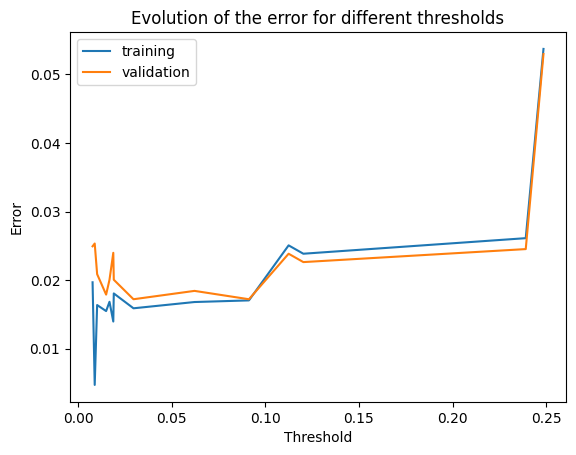

In [143]:
fig, ax = plt.subplots()
ax.plot(thresholds, treshold_train_error, label='training')
ax.plot(thresholds, treshold_val_error, label='validation')
ax.set(xlabel='Threshold', ylabel='Error')
ax.legend()
plt.title('Evolution of the error for different thresholds')
plt.show()

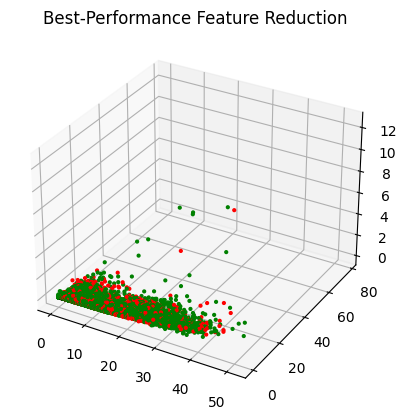

In [144]:
colors=['green' if l==0 else 'red' for l in y_train]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(best_transformation[:,0], best_transformation[:, 1], best_transformation[:, 2], s=4, alpha=1,color=colors)

plt.title('Best-Performance Feature Reduction')
plt.show()

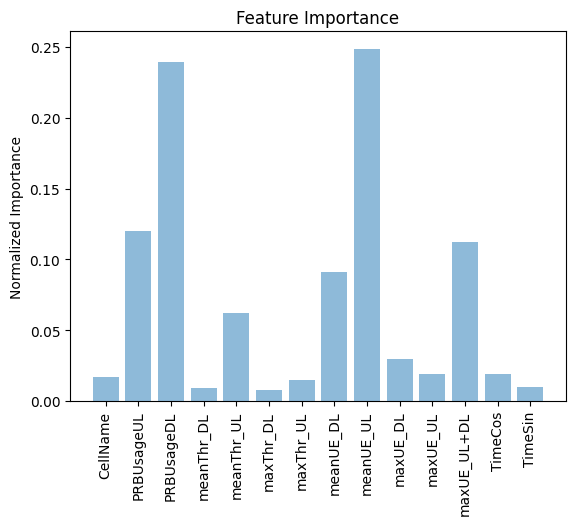

In [145]:
feature_importances = clf_GS.best_estimator_.named_steps["xgb_clf"].feature_importances_
columns = X_train_df.columns
  
fig = plt.figure() 
plt.bar(np.arange(14) , feature_importances, align='center', alpha=0.5)
plt.xticks(np.arange(14), columns, rotation='vertical')
plt.ylabel('Normalized Importance')
plt.title('Feature Importance')
plt.show()

In [106]:
select_X_test = selection.transform(X_test)
pred_test = selection_model.predict(select_X_test)

# Submission

In [147]:
submission_df = pd.DataFrame({'ID': range(1, len(pred_test)+1), 'Label': pred_test})
submission_df.to_csv('prediction26.csv', index=False)

In [148]:
predictions = pd.read_csv(path + 'prediction26.csv', delimiter=';')
predictions

,"ID,Label"
0,"1,1"
1,"2,0"
2,"3,0"
3,"4,0"
4,"5,1"
...,...
9153,"9154,0"
9154,"9155,1"
9155,"9156,0"
9156,"9157,0"
